In [18]:
import numpy as np
import pickle
from mrob.mrob import FGraph, geometry, registration, LM

In [19]:
# solve a particular problem
def solve_particular_problem(problem,method,T_gt,initialize):
    # solve problem for different methods
    problem.reset_solution()
    if initialize:
        problem.solve(registration.INITIALIZE)
    T1 = problem.get_last_pose()
    problem.solve(method)
    T2 = problem.get_last_pose()
    r = problem.print_evaluate() #outputs a list with results
    # need to evaluate initial pose and result
    r.append(T1.distance_rotation(T_gt))
    r.append(T1.distance_trans(T_gt))
    r.append(T2.distance_rotation(T_gt))
    r.append(T2.distance_trans(T_gt))
    # calculate success:
    success = 1
    if r[13]-r[15] < 0 and r[14] - r[16] < 0:
        success = 0
    r.append(success)
    return r

In [20]:
# solve a landmark problem
import time
def solve_landmark_particular_problem(problem,synthetic_points, N_planes,N_poses):
    # create FG
    graph = FGraph()
    T_gt = synthetic_points.get_ground_truth_last_pose()
    
    #plane landmakrs, for now, we know the number of planes. Uninitialized
    for p in range(N_planes):
        graph.add_node_plane_4d(np.array([1,0,0,0])) #nodes are numbered from 0. No other node should be added BEFORE
    W_z = np.identity(4)
    
    # init9ializing nodes
    graph_trajectory = []
    for t in range(N_poses):
        n1 = graph.add_node_pose_3d(geometry.SE3())#add a pose in the FG
        graph_trajectory.append(n1)
    graph.add_factor_1pose_3d(geometry.SE3(),graph_trajectory[0],1e6*np.identity(6))
    
    for t in range(N_poses):
        x = synthetic_points.get_point_cloud(t)
        ids = synthetic_points.get_point_plane_ids(t)
        X=[]
        # plane ids are consecutive, if not iterate over a list
        for p in range(N_planes):
            X.append([])

        # group points
        for n in range(len(x)):
            X[ids[n]].append(x[n])
        # estimate plane observation
        for p in range(N_planes):
            P = np.vstack((np.array(X[p]).T, np.ones(len(X[p]))))
            z = calculate_plane(P).reshape(4,1)
            z = z / np.linalg.norm(z[:3]) * np.sign(z[-1]) # this is to ensure that signs of pi and z_pi are the same
            # add plane observation
            graph.add_factor_1pose_1plane_4d(z,graph_trajectory[t],p,W_z) #it requires plane with [n,d], st.|n|=1
    
    
    # solve graph TODO time
    t0= time.process_time()
    graph.solve(LM)
    t1 = time.process_time() - t0
    x = graph.get_estimated_state()
    T1 = geometry.SE3(x[-1])
    r = [0]*15
    r[4] = t1*1e6

    
    # need to evaluate initial pose and result
    r.append(T1.distance_rotation(T_gt))
    r.append(T1.distance_trans(T_gt))
    # calculate success:
    success = 1
    if r[15] > 1.0 and r[16] > 1.0:
        success = 0
    r.append(success)
    return r

# function for calculating planes, in homogenous coords
def calculate_plane(X):
    P = X @ X.T
    v, vect = np.linalg.eig(P)
    min_idex = np.where(v == np.amin(v))
    #print(v)
    #print(vect)
    if len(min_idex[0]) != 1:
        min_idex = min_idex[0][0]
    return np.real(vect[:,min_idex]) # to avoid rare cases of complex solution...

In [21]:
# create problem and evaluate
def solve_new_problem(result,N_points,N_planes,N_poses, point_noise,bias):
    synthetic_points = registration.CreatePoints(N_points,N_planes,N_poses, point_noise,bias)#add bias noise param
    problem = registration.PlaneRegistration() #empty creator
    synthetic_points.create_plane_registration(problem)
    T_gt = synthetic_points.get_ground_truth_last_pose()
    

    #1.1) Gradinent ini
    r = solve_particular_problem(problem, registration.GRADIENT_BENGIOS_NAG,T_gt,True)
    result['grad-ini'].append(r)
    
    # 1.2) Gradient
    r = solve_particular_problem(problem, registration.GRADIENT_BENGIOS_NAG,T_gt,False)
    result['grad'].append(r)

    # 2.1) Solve GN Hessian optimization INI
    r = solve_particular_problem(problem, registration.GN_HESSIAN,T_gt,True)
    result['gn-ini'].append(r)

    # 2.2) Solve GN Hessian optimization
    r = solve_particular_problem(problem, registration.GN_HESSIAN,T_gt,False)
    result['gn'].append(r)
    
    # 3.1) Solve LM Ellipse optimization INI
    r = solve_particular_problem(problem, registration.LM_ELLIP,T_gt,True)
    result['lm-e-ini'].append(r)
    
    # 3.2) Solve LM Ellipse optimization 
    r = solve_particular_problem(problem, registration.LM_ELLIP,T_gt,False)
    result['lm-e'].append(r)
    
    # 4.1) Solve LM Sphere optimization INI
    r = solve_particular_problem(problem, registration.LM_SPHER,T_gt,True)
    result['lm-s-ini'].append(r)
    
    # 4.2) Solve LM Sphere optimization
    r = solve_particular_problem(problem, registration.LM_SPHER,T_gt,False)
    result['lm-s'].append(r)
    
    # 5. Plane landmark
    r = solve_landmark_particular_problem(problem,synthetic_points,N_planes,N_poses)
    result['land'].append(r)
    
    return result

In [24]:
# Sweep over the parameters and create some statistics. Parameters
results={} #dictionary for results
results['grad'] = []
results['gn'] = []
results['lm-e'] = []
results['lm-s'] = []
results['grad-ini'] = []
results['gn-ini'] = []
results['lm-e-ini'] = []
results['lm-s-ini'] = []
results['land'] = []

N_points_frame = [20]
N_planes = [3]
N_poses = [3]
point_noise = [0.005,0.01, 0.03]
N_bias = [0.01]#bias in the plane does not help much, but adds noise to the initial solution by arun

In [25]:
for n in N_points_frame:
    for pi in N_planes:
        for p in N_poses:
            for s in point_noise:
                for bias in N_bias:
                    print('Iteration = ',n,pi,p,s)
                    for samples in range(100):
                        solve_new_problem(results,n,pi,p,s,bias)
with open("res.txt", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

Iteration =  20 3 3 0.005
Iteration =  20 3 3 0.01
Iteration =  20 3 3 0.03


# Evaluation of results

In [26]:
import matplotlib.pyplot as plt
# sets the default fonts on matplotlib to type2 postcript
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [28]:
#file = "res_points100-750.txt"
#file = "res_points20-200.txt"
file = "res.txt"
#file = "res.txt"

with open(file, "rb") as fp:   # Unpickling
    res = pickle.load(fp)
results = {}
results['grad'] = np.array(res['grad'])
results['gn'] = np.array(res['gn'])
results['lm-e'] = np.array(res['lm-e'])
results['lm-s'] = np.array(res['lm-s'])
results['grad-ini'] = np.array(res['grad-ini'])
results['gn-ini'] = np.array(res['gn-ini'])
results['lm-e-ini'] = np.array(res['lm-e-ini'])
results['lm-s-ini'] = np.array(res['lm-s-ini'])
results['land'] = np.array(res['land'])

In [29]:
# analize results
# Nplanes[0], Nposes[1], Npoints[2], iters[3],  process-time[4],
    #         ini_error[5] error[6], eigenvalues[7-12]
    #         erro_ini_rot[13] erro_ini_tran[14] erro_rot[15] erro_tran[16]
def print_statistics(index, results):
    print('Gradient    : ', np.percentile(results['grad'][:,index],25),
          np.median(results['grad'][:,index]), np.percentile(results['grad'][:,index],75))
    print('Gradient-ini: ', np.percentile(results['grad-ini'][:,index],25),
      np.median(results['grad-ini'][:,index]), np.percentile(results['grad-ini'][:,index],75))
    x = results['gn'][:,index][np.logical_not(np.isnan(results['gn'][:,index]))]
    print('Gauss Newton: ', np.percentile(x,25),
          np.median(x), np.percentile(x,75))
    x = results['gn-ini'][:,index][np.logical_not(np.isnan(results['gn-ini'][:,index]))]
    print('Gauss New ini: ', np.percentile(x,25),
          np.median(x), np.percentile(x,75))
    print('LM Ellispe   : ', np.percentile(results['lm-e'][:,index],25),
          np.median(results['lm-e'][:,index]), np.percentile(results['lm-e'][:,index],75))
    print('LM Ellisp INI: ', np.percentile(results['lm-e-ini'][:,index],25),
          np.median(results['lm-e-ini'][:,index]), np.percentile(results['lm-e-ini'][:,index],75))
    print('LM Sphere    : ', np.percentile(results['lm-s'][:,index],25),
          np.median(results['lm-s'][:,index]), np.percentile(results['lm-s'][:,index],75))
    print('LM Sphere INI: ', np.percentile(results['lm-s-ini'][:,index],25),
          np.median(results['lm-s-ini'][:,index]), np.percentile(results['lm-s-ini'][:,index],75))
    print('FGraph Land  : ', np.percentile(results['land'][:,index],25),
          np.median(results['land'][:,index]), np.percentile(results['land'][:,index],75))

def print_mean(index,results):
    print('Gradient    : ', np.mean(results['grad'][:,index]), np.std(results['grad'][:,index]))
    print('Gradient-ini: ', np.mean(results['grad-ini'][:,index]), np.std(results['grad-ini'][:,index]))
    x = results['gn'][:,index][np.logical_not(np.isnan(results['gn'][:,index]))]
    print('Gauss Newton: ', np.mean(x), np.std(x))
    x = results['gn-ini'][:,index][np.logical_not(np.isnan(results['gn-ini'][:,index]))]
    print('Gauss New ini: ', np.mean(x), np.std(x))
    print('LM Ellispe   : ', np.mean(results['lm-e'][:,index]), np.std(results['lm-e'][:,index]))
    print('LM Ellisp INI: ', np.mean(results['lm-e-ini'][:,index]), np.std(results['lm-e-ini'][:,index]))
    print('FGraph landm: ', np.mean(results['land'][:,index]), np.std(results['land'][:,index]))

In [30]:
print('Mean Iterations')
#print_statistics(3,results)
print_mean(3,results)
print('Mean Processing time')
#print_statistics(4,results)
print_mean(4,results)
print('Rotation error')
print_statistics(15,results)
print('Translation error')
print_statistics(16,results)
print('Success rate')
print_mean(17,results)

Mean Iterations
Gradient    :  460.0733333333333 320.3468348871614
Gradient-ini:  202.76 956.6413690964168
Gauss Newton:  79.62666666666667 28.032135527323316
Gauss New ini:  42.28 38.301892033336074
LM Ellispe   :  67.82666666666667 28.518589648780942
LM Ellisp INI:  20.643333333333334 20.177283981965683
FGraph landm:  0.0 0.0
Mean Processing time
Gradient    :  4537.116666666667 3363.804486449169
Gradient-ini:  1953.23 9033.066366251274
Gauss Newton:  8912.286666666667 3455.257258799826
Gauss New ini:  4783.126666666667 4443.019022086471
LM Ellispe   :  8302.97 4253.818490380144
LM Ellisp INI:  2436.33 2674.1114426602844
FGraph landm:  3489.5833333333335 6872.434811844748
Rotation error
Gradient    :  0.11657821737374058 0.18665151057610663 0.36299805918650707
Gradient-ini:  0.048091817759878405 0.07556040865965982 0.11875726881597509
Gauss Newton:  1.3710330677100382 2.031880491341022 2.6256076854268127
Gauss New ini:  0.01699001061030542 0.04283447482334567 1.6751459825803805
LM El

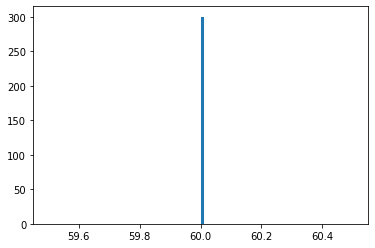

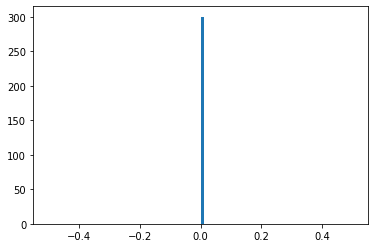

In [31]:
i=2
plt.hist(results['lm-e-ini'][:,i],100)
plt.figure()
plt.hist(results['land'][:,i],100)
plt.show()

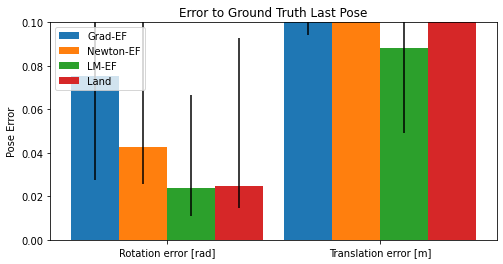

In [32]:
def statistics_errors(res):
    xrot = res[:,15][np.logical_not(np.isnan(res[:,15]))]
    xtra = res[:,16][np.logical_not(np.isnan(res[:,16]))]
    return [[np.median(xrot), np.median(xtra)],
            [np.percentile(xrot,25), np.percentile(xtra,25)],
            [np.percentile(xrot,75), np.percentile(xtra,75)]]

# plot bar for static overall conditions

labels = ['Rotation error [rad]', 'Translation error [m]']
methods = ['Grad-EF', 'Newton-EF', 'LM-EF','Land']

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

res0 = statistics_errors(results['grad-ini'])
res1 = statistics_errors(results['gn-ini'])
res2 = statistics_errors(results['lm-e-ini'])
res3 = statistics_errors(results['land'])


fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(x - width*0.75, res0[0], width/2, yerr=[res0[1],res0[2]], label=methods[0])
rects2 = ax.bar(x - width*0.25, res1[0], width/2, yerr=[res1[1],res1[2]], label=methods[1])
rects3 = ax.bar(x + width*0.25, res2[0], width/2, yerr=[res2[1],res2[2]], label=methods[2])
rects4 = ax.bar(x + width*0.75, res3[0], width/2, yerr=[res3[1],res3[2]], label=methods[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,0.1])
ax.set_ylabel('Pose Error')
ax.set_title('Error to Ground Truth Last Pose')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
plt.savefig('error-gt-bar.pdf', bbox_inches='tight')

IndexError: list index out of range

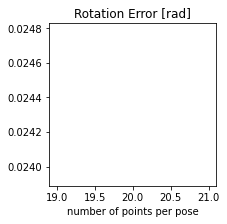

In [33]:
# plot function of poses
# preprocess results
def create_index_points(N_ref):
    cont = 0
    ind = []
    for n in N_points_frame:
        for pi in N_planes:
            for p in N_poses:
                for s in point_noise:
                    for samples in range(100):
                        if n == N_ref:
                            ind.append(cont)
                        cont = cont+1
    return ind

# create statistics for each number of points
x = N_points_frame
res_ef = []
res_land = []
for n in N_points_frame:
    ind = create_index_points(n)
    tmp = statistics_errors(results['lm-e-ini'][ind,:])
    res_ef.append(np.array(tmp).reshape(1,6))
    tmp = statistics_errors(results['land'][ind,:])
    res_land.append(np.array(tmp).reshape(1,6))
plt.figure(figsize=(3,3))
res_ef = np.asarray(res_ef)[:,0,:]
plt.plot(x, res_ef[:,0], 'g', label='LM-EF')
#plt.fill_between(x,res_ef[:,2],res_ef[:,4], color='green', alpha = 0.2 )
res_land = np.asarray(res_land)[:,0,:]
plt.plot(x, res_land[:,0], 'r--', label='Landmark')
#plt.fill_between(x,res_land[:,2],res_land[:,4], color='red', alpha = 0.2 )
plt.title('Rotation Error [rad]')
plt.xlabel('number of points per pose')
plt.xticks((x[0],x[3],x[4],x[5]))
plt.legend()
plt.savefig('rotation-number-points.pdf', bbox_inches='tight')

# Translation error
plt.figure(figsize=(3,3))
plt.plot(x, res_ef[:,1], 'g', label='LM-EF')
#plt.fill_between(x,res_ef[:,3],res_ef[:,5], color='green', alpha = 0.2 )
plt.plot(x, res_land[:,1], 'r--', label='Landmark')
#plt.fill_between(x,res_land[:,3],res_land[:,5], color='red', alpha = 0.2 )
plt.title('Translation Error [m]')
plt.xlabel('number of points per pose')
plt.xticks((x[0],x[3],x[4],x[5]))
plt.legend()
plt.savefig('trans-number-points.pdf', bbox_inches='tight')

In [34]:
# create problem and evaluate
def solve_new_problem_lm(result,N_points,N_planes,N_poses, point_noise,bias):
    synthetic_points = registration.CreatePoints(N_points,N_planes,N_poses, point_noise,bias)#add bias noise param
    problem = registration.PlaneRegistration() #empty creator
    synthetic_points.create_plane_registration(problem)
    T_gt = synthetic_points.get_ground_truth_last_pose()
    
    # 3.1) Solve LM Ellipse optimization INI
    r = solve_particular_problem(problem, registration.LM_ELLIP,T_gt,True)
    result.append(r)

In [37]:
# create an example with a fixed number of points per plane (1 for example) and augment with poses
# rerun cell with defintoin of results as lists
res=[]
for n in [3]:
    for pi in [3]:
        for p in np.arange(2,20):
            for s in [0.005]: # point_noise:
                for bias in [0.0]: #N_bias:
                    print('Iteration = ',n,pi,p,s)
                    for samples in range(100):
                        solve_new_problem_lm(res,n,pi,p,s,bias)

Iteration =  3 3 2 0.005
Iteration =  3 3 3 0.005
Iteration =  3 3 4 0.005
Iteration =  3 3 5 0.005
Iteration =  3 3 6 0.005
Iteration =  3 3 7 0.005
Iteration =  3 3 8 0.005
Iteration =  3 3 9 0.005
Iteration =  3 3 10 0.005
Iteration =  3 3 11 0.005
Iteration =  3 3 12 0.005
Iteration =  3 3 13 0.005
Iteration =  3 3 14 0.005
Iteration =  3 3 15 0.005
Iteration =  3 3 16 0.005
Iteration =  3 3 17 0.005
Iteration =  3 3 18 0.005
Iteration =  3 3 19 0.005


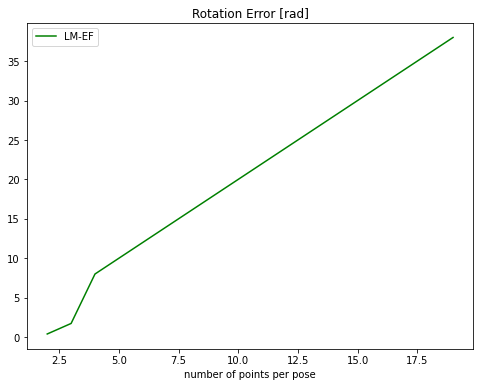

In [38]:
x = np.arange(2,20)
res_ef = []
res = np.asarray(res)
for n in x:
    ind = np.where(res[:,1]== n)
    tmp = statistics_errors(res[ind,:])
    res_ef.append(np.array(tmp).reshape(1,6))
plt.figure(figsize=(8,6))
res_ef = np.asarray(res_ef)[:,0,:]
plt.plot(x, res_ef[:,0], 'g', label='LM-EF')
#plt.fill_between(x,res_ef[:,2],res_ef[:,4], color='green', alpha = 0.2 )
plt.title('Rotation Error [rad]')
plt.xlabel('number of points per pose')
plt.legend()
# the problem becomes illposes and diverges quickly...
#plt.savefig('rotation-1point-poses.pdf', bbox_inches='tight')

In [39]:
np.median(res[:,5])

-1.96145181543259e-16

In [40]:
# function to plot any of the historgrams results:
def plot_hist(index, results):
    plt.figure(figsize=(18,8))
    plt.subplot(2,4,1)
    plt.hist(results['grad'][:,index],  label='grad')
    plt.title('Gradient')
    
    plt.subplot(2,4,2)
    plt.hist(results['gn'][:,index],  label='gn')
    plt.title('Gauss Newton')
    
    plt.subplot(2,4,3)
    plt.hist(results['lm-e'][:,index],  label='lm-e')
    plt.title('LM Ellipse')
    
    plt.subplot(2,4,4)
    plt.hist(results['lm-s'][:,index],  label='lm-s')
    plt.title('LM spehere')
    
    plt.subplot(2,4,5)
    plt.hist(results['grad-ini'][:,index],  label='grad-ini')
    plt.title('Gradient-INI')
    
    plt.subplot(2,4,6)
    plt.hist(results['gn-ini'][:,index],  label='gn')
    plt.title('Gauss Newton INI')
    
    plt.subplot(2,4,7)
    plt.hist(results['lm-e-ini'][:,index],  label='lm-e')
    plt.title('LM Ellipse INI')
    
    plt.subplot(2,4,8)
    plt.hist(results['lm-s-ini'][:,index],  label='lm-s')
    plt.title('LM spehere INI')

In [41]:
# function to plot any of the historgrams results:
def plot_all_hist(x):
    plt.figure(figsize=(18,9))
    t =1
    for index in [3,4,5,6,13,14,15,16]:
        plt.subplot(2,4,t)
        plt.hist(x[:,index])
        plt.title(index)
        t = t+1

In [42]:
#function to plot any of the results
def plot_results(index,results):
    plt.figure(figsize=(8,5))
    plt.plot(results['grad'],  label='grad')
    #TODO

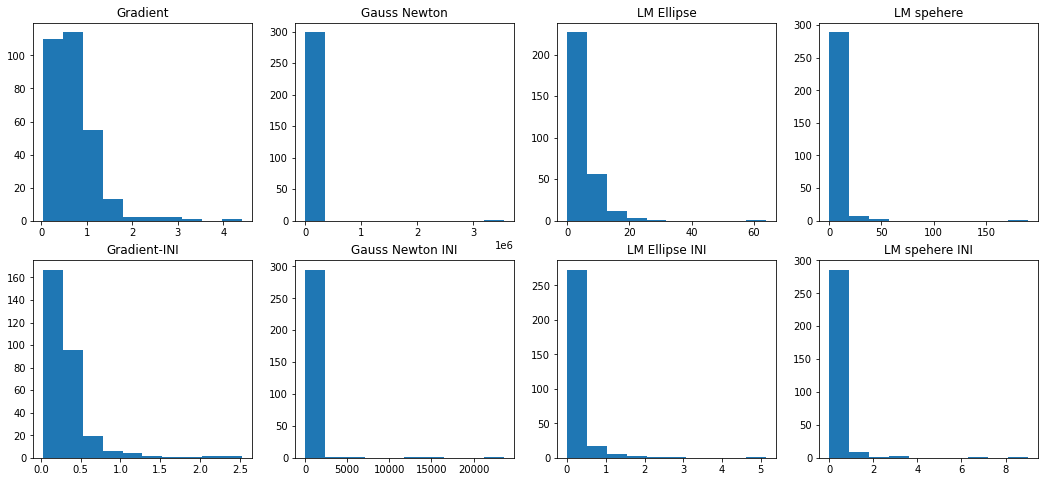

In [43]:
# analize results
# Nplanes[0], Nposes[1], Npoints[2], iters[3],  process-time[4],
    #         ini_error[5] error[6], eigenvalues[7-12]
    #         erro_ini_rot[13] erro_ini_tran[14] erro_rot[15] erro_tran[16]
plot_hist(16,results)

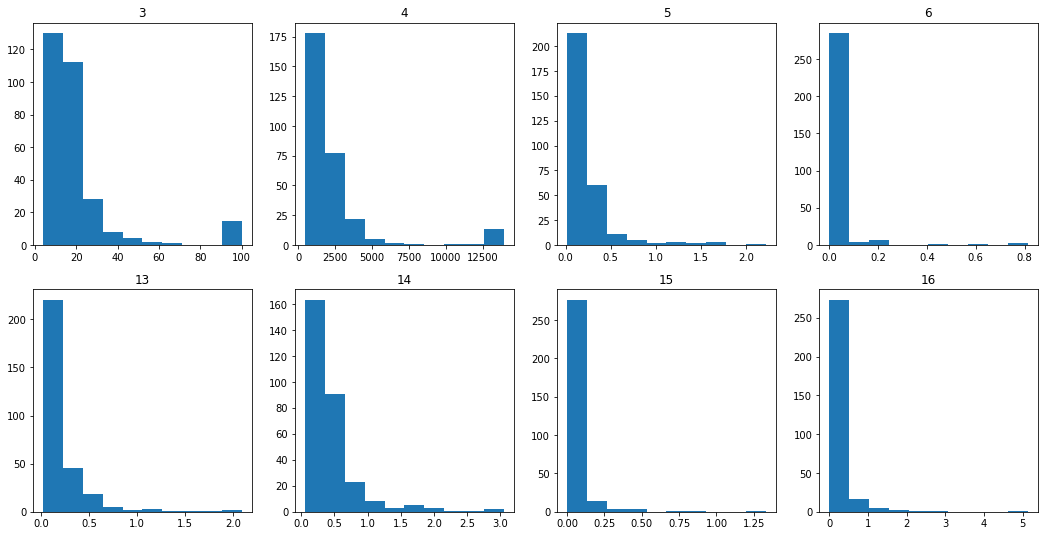

In [44]:
plot_all_hist(results['lm-e-ini'])

# Plane Landmark

In [45]:
#moved up to do a single 

In [46]:
# create problem and evaluate
def solve_new_problem_landmark(result,N_points,N_planes,N_poses, point_noise):
    synthetic_points = registration.CreatePoints(N_points,N_planes,N_poses, point_noise,0.1)
    problem = registration.PlaneRegistration()
    synthetic_points.create_plane_registration(problem)
    T_gt = synthetic_points.get_ground_truth_last_pose()
    

    # 3.1) Solve LM Ellipse optimization INI
    r = solve_particular_problem(problem, registration.LM_ELLIP,T_gt,True)
    result['ef'].append(r)
    
    r = solve_landmark_particular_problem(problem,synthetic_points,N_planes,N_poses)
    result['land'].append(r)

In [47]:
results_land = {}
results_land['ef']=[]
results_land['land']=[]
solve_new_problem_landmark(results_land,50,3,3,0.05)

In [48]:
# analize results
# Nplanes[0], Nposes[1], Npoints[2], iters[3],  process-time[4],
    #         ini_error[5] error[6], eigenvalues[7-12]
    #         erro_ini_rot[13] erro_ini_tran[14] erro_rot[15] erro_tran[16]
i=16
print(results_land['ef'][0][i])
print(results_land['land'][0][i])

0.10468393020794706
3.717437078070865
